# Introduction

In this note book, we also build predictive models using naive bayes.

# Importing Packages and Data

### Importing Packages

In [27]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

### Importing Data

In [28]:
# Import the data
player_stats_and_awards = pd.read_csv('./data/player_stats_and_awards.csv')

In [29]:
# All the features of the data
player_stats_and_awards.columns

Index(['Player', 'Birth Year', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Year_start', 'Year_end', 'Length', 'HOF', 'AllStar_MVP', 'Final_MVP',
       'DPOY', 'Final', 'Champion', 'AllStar', 'First team', 'Second team',
       'Third team', 'MVPs'],
      dtype='object')

Here, we choose to work with players who start their careers after 1982 and finish their careers before 2015. We also normalized all the features except 'HOF.'   

In [30]:
# data_in: data for training the model
data_in = player_stats_and_awards.query('Year_start >= 1982 & Year_end <= 2015')

# data_future: data for predicting future HOF inductees, need to be normalized the same way as data_in
data_future = player_stats_and_awards.query('Year_end > 2015')

# normalized data_in and data_future as X and X_future
X = data_in.drop(["Player","HOF"], axis = 1)
normalization_offset = X.mean()
normalization_scaling = X.std()
X = (X - normalization_offset)/normalization_scaling

X_future = data_future.drop(["Player","HOF"], axis = 1)
X_future = (X_future - normalization_offset)/normalization_scaling


y = data_in["HOF"]
data_normalized = pd.concat([X,y], axis=1)

### Precision, Recall And F1 score

In [31]:
def Precision_Func(y_true,y_pred):
    y_true_np = np.array(y_true)
    y_pred_np= np.array(y_pred)
    y_true_positive_np = y_true_np & y_pred_np
    
    if sum(y_pred_np) > 0:
        precision = sum(y_true_positive_np)/sum(y_pred_np) 
    else:
        precision = -1 # if the no predictive positive, return a signal -1 
    
    return precision

In [32]:
def Recall_Func(y_true,y_pred):
    y_true_np = np.array(y_true)
    y_pred_np= np.array(y_pred)
    y_true_positive_np = y_true_np & y_pred_np
    
    if sum(y_true_np) > 0:
        recall = sum(y_true_positive_np)/sum(y_true_np) 
    else:
        recall = -1 # if the no true element, return a signal -1 
    
    return recall

In [33]:
def F1_Score_Func(y_true,y_pred):
    precision = Precision_Func(y_true,y_pred)
    recall = Recall_Func(y_true,y_pred)
    
    if (precision > 0) & (recall > 0):
        f1 = 2*precision*recall / (precision + recall)
    elif (precision == 0 ) & (recall == 0):
        # the limit of no true positive is f1 = 0
        f1 = 0
    elif (precision < 0) & (recall >= 0):
        # no predicted positive while true elements are present, it is reasonable to set f1 to zero
        f1 = 0
    elif (recall < 0) :
        # no ture elements to be learned from, there is issue in the training set
        f1 = -1
        print('There are no true examples in the training set!')
    
    return f1

# Naive Bayes

### One representing feature, AllStar

We first plot the distribution of number of All stars with respect to whether the player is a Hall of Fame inductee. 

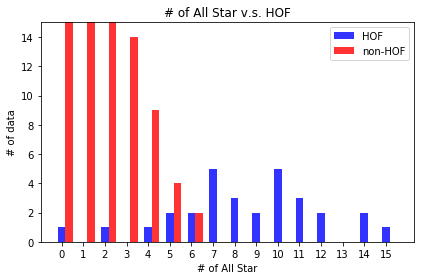

In [34]:
X_in = data_in['AllStar']
y_in = data_normalized['HOF']


# data to plot
n_groups = max(X_in)- min(X_in)+1
index = np.arange(n_groups)
X_in_1 = X_in[y_in==1]
X_in_1_hist = [sum(X_in_1==i) for i in list(index)]
X_in_0 = X_in[y_in==0]
X_in_0_hist = [sum(X_in_0==i) for i in list(index)]
 
# create plot
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, X_in_1_hist, bar_width,
alpha=opacity,
color='b',
label='HOF')
 
rects2 = plt.bar(index + bar_width, X_in_0_hist, bar_width,
alpha=opacity,
color='r',
label='non-HOF')

plt.ylim(0,15)
plt.xticks(index)
plt.xlabel('# of All Star')
plt.ylabel('# of data')
plt.title('# of All Star v.s. HOF')
plt.legend()
 
plt.tight_layout()
plt.show()

This plot shows that players who have played in the all star games at least seven times are all Hall of Fame inductees. Players who have played six times have one half probability being inducted. And the probability goes down quickly for players who play less then five times. We now explore people who are Hall of Fame inductees but have only played at most six times. However, the distribution for non-HOF is very different from gaussian so we expect the performance would not be good.

In [35]:
data_in.query('(AllStar<=6) & (HOF==1)')[['Player','AllStar']].sort_values('AllStar')

,Player,AllStar
169,Arvydas Sabonis,0.0
685,Dennis Rodman,2.0
2104,Ralph Sampson,4.0
446,Chris Mullin,5.0
2152,Reggie Miller,5.0
1309,Joe Dumars,6.0
1919,Mitch Richmond,6.0


The first player, Arvydas Sabonis, is inducted in recognition of his achievement in international competition but has no outstanding NBA career. This person could be an outlier. The rest of them all have outstanding NBA careers.

We now apply logistic regression and show the probability of being inducted versus the number of all star game played.

In [36]:
X_in = np.c_[X['AllStar']]
y_in = y
model = GaussianNB()
model.fit(X_in, y_in)

GaussianNB(priors=None)

In [37]:
y_pred = model.predict(X_in)
print([Precision_Func(y,y_pred),Recall_Func(y,y_pred),F1_Score_Func(y,y_pred)])

[0.49122807017543857, 0.9333333333333333, 0.6436781609195402]


The performance is much worse than logistic regression (see notebook feature-selectrion-logictic-regression)

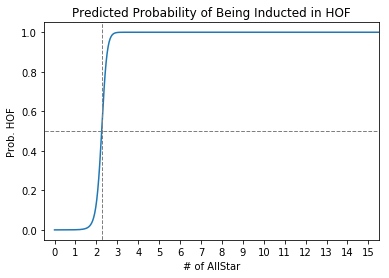

In [38]:
X_Full = pd.DataFrame(data = {'AllStar': np.linspace(0,16,1000)})

prob_Full = model.predict_proba((X_Full- normalization_offset['AllStar'])/normalization_scaling['AllStar'])[:,1]
plt.plot(X_Full,prob_Full)
plt.plot([-1,16],[0.5,0.5],color = 'tab:gray', linestyle='--',linewidth = 1.0)
plt.plot(X_Full[prob_Full>0.5].min().values*[1,1],[-0.1,1.1],color = 'tab:gray', linestyle='--',linewidth = 1.0)
plt.xticks(range(0,16))
plt.xlim(-0.5,15.5)
plt.ylim(-0.05,1.05)
_ = plt.xlabel('# of AllStar')
_ = plt.ylabel('Prob. HOF')
_ = plt.title('Predicted Probability of Being Inducted in HOF')

plt.savefig('./figures/naive-bayes/probability-one-rep-feature.png')
plt.show()

The results shows that the players who have played more than two all star games have probability higher than 50% to be inducted in Hall of Fame. We now see how this applies to the players who finish their careers after 2015 or are still playing.

In [39]:
X_future_in = np.c_[X_future['AllStar']]

data_future_pred = pd.DataFrame()
data_future_pred['Player'] = data_future['Player']
data_future_pred['AllStar'] = data_future['AllStar']
data_future_pred['HOF'] = model.predict(X_future_in)
data_future_pred['HOF_Prob'] = model.predict_proba(X_future_in)[:,1]

##### Players who will be inducted:

In [40]:
data_future_pred[(data_future_pred['HOF']==1)][['Player','HOF_Prob']].sort_values('HOF_Prob',ascending = False)

,Player,HOF_Prob
2655,Vince Carter,1.000000
1557,Kobe Bryant,1.000000
1520,Kevin Garnett,1.000000
1517,Kevin Durant,1.000000
1580,Kyrie Irving,1.000000
82,Amar'e Stoudemire,1.000000
1583,LaMarcus Aldridge,1.000000
1313,Joe Johnson,1.000000
1628,LeBron James,1.000000
1141,James Harden,1.000000


In [41]:
# players that are predicted to be inducted
print(data_future_pred[(data_future_pred['HOF']==1)]['Player'].tolist())

['Al Horford', "Amar'e Stoudemire", 'Anthony Davis', 'Blake Griffin', 'Carmelo Anthony', 'Chris Bosh', 'Chris Paul', 'Damian Lillard', 'DeMar DeRozan', 'DeMarcus Cousins', 'Deron Williams', 'Derrick Rose', 'Dirk Nowitzki', 'Draymond Green', 'Dwight Howard', 'Dwyane Wade', 'Giannis Antetokounmpo', 'James Harden', 'Jimmy Butler', 'Joe Johnson', 'John Wall', 'Kawhi Leonard', 'Kemba Walker', 'Kevin Durant', 'Kevin Garnett', 'Kevin Love', 'Klay Thompson', 'Kobe Bryant', 'Kyle Lowry', 'Kyrie Irving', 'LaMarcus Aldridge', 'LeBron James', 'Marc Gasol', 'Pau Gasol', 'Paul George', 'Paul Millsap', 'Paul Pierce', 'Rajon Rondo', 'Russell Westbrook', 'Stephen Curry', 'Tim Duncan', 'Tony Parker', 'Vince Carter']


#### Compare the predictions using logistic regresson: 

We find that all players who have played at least 3 all star games are pridected to be inducted into Hall of Fame. This includes all players that the logistic regression model using only one representing feature doesn't predict to be Hall of famers but are expected to be inducted in the future based on our impression:

In [42]:
data_future_pred[(data_future_pred['AllStar']==5)][['Player','HOF_Prob']]

,Player,HOF_Prob
29,Al Horford,1.0
1364,John Wall,1.0
1527,Kevin Love,1.0
1556,Klay Thompson,1.0
1574,Kyle Lowry,1.0


In [43]:
data_future_pred.query('(Player == "Klay Thompson") | (Player == "Rajon Rondo")')[['Player','HOF_Prob','AllStar']]

,Player,HOF_Prob,AllStar
1556,Klay Thompson,1.0,5.0
2100,Rajon Rondo,1.0,4.0


However, as the precision on the training set is only 50%. Half of the players listed above might not actually get inducted in the future. 

### Two Representing features, AllStar and VORP

We first plot the dependence of whether the player is a Hall of Fame inductee on the number of all star games he plays and his value over replacement player (VORP). 

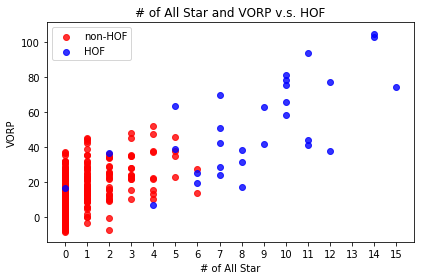

In [44]:
X_in = data_in[['AllStar','VORP']]
y_in = data_normalized['HOF']


# data to plot
X_in_1 = X_in[y_in==1]
X_in_0 = X_in[y_in==0]
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
opacity = 0.8

plt.scatter(X_in_0['AllStar'], X_in_0['VORP'],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')
plt.scatter(X_in_1['AllStar'], X_in_1['VORP'],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')


plt.xticks(index)
plt.xlabel('# of All Star')
plt.ylabel('VORP')
plt.title('# of All Star and VORP v.s. HOF')
plt.legend()
 
plt.tight_layout()
plt.show()

We now apply naive Bayes and show the probability of being inducted versus the number of all star game played.

In [45]:
X_in = X[['AllStar','VORP']]
y_in = y
model = GaussianNB()
model.fit(X_in, y_in)

GaussianNB(priors=None)

In [46]:
y_pred = model.predict(X_in)
print([Precision_Func(y,y_pred),Recall_Func(y,y_pred),F1_Score_Func(y,y_pred)])

[0.3625, 0.9666666666666667, 0.5272727272727272]


In [47]:
print(plt.cm.get_cmap(None, 2))

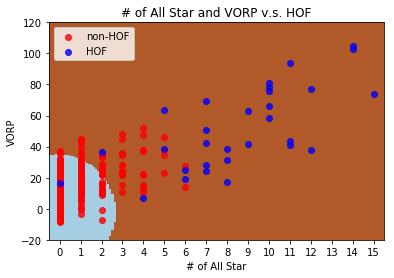

In [48]:
h = 0.1
x_min = data_in[['AllStar']].min().values-1; x_max = data_in[['AllStar']].max().values+1;
y_min = data_in[['VORP']].min().values-20; y_max = data_in[['VORP']].max().values+20;
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
Z = model.predict(np.c_[(xx.ravel()-normalization_offset[['AllStar']].values)/normalization_scaling[['AllStar']].values, 
                        (yy.ravel()-normalization_offset[['VORP']].values)/normalization_scaling[['VORP']].values])

Z = Z.reshape(xx.shape)

Z_prob = model.predict_proba(np.c_[(xx.ravel()-normalization_offset[['AllStar']].values)/normalization_scaling[['AllStar']].values, 
                        (yy.ravel()-normalization_offset[['VORP']].values)/normalization_scaling[['VORP']].values])

Z_prob = Z_prob[:,1].reshape(xx.shape)



plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X_in_0['AllStar'], X_in_0['VORP'],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')
plt.scatter(X_in_1['AllStar'], X_in_1['VORP'],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')
plt.xlim(-0.5,15.5)
plt.ylim(-20,120)

plt.xticks(index)
plt.xlabel('# of All Star')
plt.ylabel('VORP')
plt.title('# of All Star and VORP v.s. HOF')
plt.legend()
plt.savefig('./figures/naive-bayes/classification-two-rep-feature.png')

plt.show()

In [49]:
X_future_in = X_future[['AllStar','VORP']]

data_future_pred = pd.DataFrame()
data_future_pred['Player'] = data_future['Player']
data_future_pred['AllStar'] = data_future['AllStar']
data_future_pred['VORP'] = data_future['VORP']
data_future_pred['HOF'] = model.predict(X_future_in)
data_future_pred['HOF_Prob'] = model.predict_proba(X_future_in)[:,1]

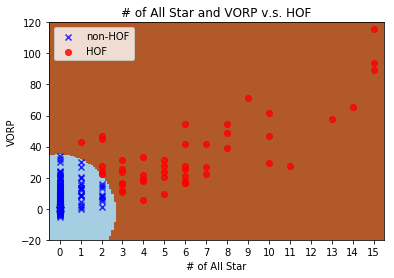

In [50]:
X_future_0 = data_future_pred[data_future_pred['HOF'] == 0]
X_future_1 = data_future_pred[data_future_pred['HOF'] == 1]

plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X_future_0['AllStar'], X_future_0['VORP'],
            alpha=opacity,
            color='b',
            marker = 'x',label='non-HOF')
plt.scatter(X_future_1['AllStar'], X_future_1['VORP'],
            alpha=opacity,
            color='r',
            marker = 'o',label='HOF')
plt.xlim(-0.5,15.5)
plt.ylim(-20,120)

plt.xticks(index)
plt.xlabel('# of All Star')
plt.ylabel('VORP')
plt.title('# of All Star and VORP v.s. HOF')
plt.legend()
plt.show()

We find that all players who the logistic regression model using only one representing feature doesn't predict to be Hall of famers but are expected to be inducted in the future are predicted to be inducted based on naive bayes.

In [51]:
data_future_pred[(data_future_pred['AllStar']==5)][['Player','HOF_Prob']]

,Player,HOF_Prob
29,Al Horford,1.0
1364,John Wall,1.0
1527,Kevin Love,1.0
1556,Klay Thompson,1.0
1574,Kyle Lowry,1.0


In [52]:
data_future_pred.query('(Player == "Klay Thompson") | (Player == "Rajon Rondo")')[['Player','HOF_Prob','AllStar']]

,Player,HOF_Prob,AllStar
1556,Klay Thompson,1.0,5.0
2100,Rajon Rondo,1.0,4.0


However, as the precision on the training set is now lowered to 36%. Roughy two third of the players listed above might not actually get inducted in the future. 